<a href="https://colab.research.google.com/github/rituparrna33/Failed-order-analysis-of-Gett-cab-app/blob/main/Insights_from_failed_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

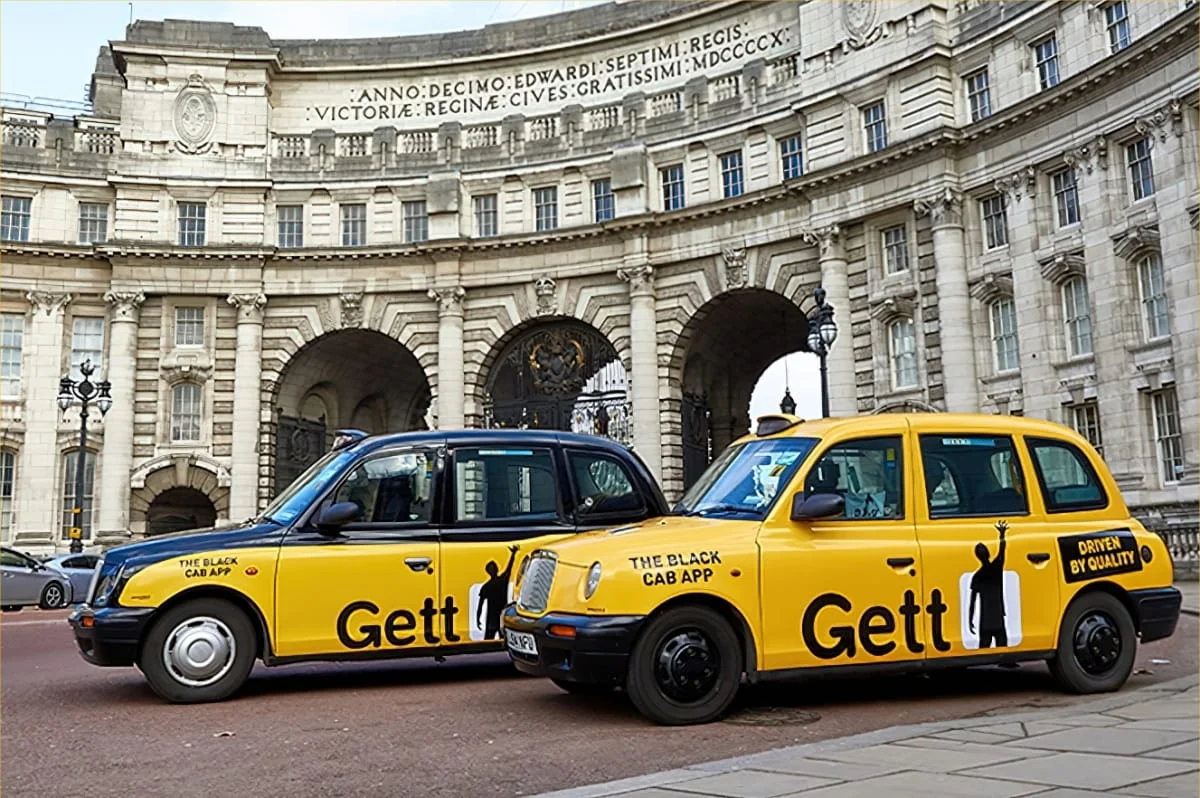


Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, I would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

#Analysis Objectives


Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

Plot the distribution of average ETA by hours. How can this plot be explained?

#Data Description
two data sets: data_orders and data_offers, both being stored in a CSV format. The data_orders data set contains the following columns:

order_datetime - time of the order
origin_longitude - longitude of the order
origin_latitude - latitude of the order
m_order_eta - time before order arrival
order_gk - order number
order_status_key - status, an enumeration consisting of the following mapping:
4 - cancelled by client,
9 - cancelled by system, i.e., a reject
is_driver_assigned_key - whether a driver has been assigned
cancellation_time_in_seconds - how many seconds passed before cancellation
The data_offers data set is a simple map with 2 columns:

order_gk - order number, associated with the same column from the orders data set
offer_id - ID of an offer



Tasks
1. clean
2. join
3. remove/impute values
4. categorise, filter, groupby
5. visualise
6. Strategise

In [ ]:
##importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


datetime.datetime(2023, 2, 14, 18, 50, 58, 113266)

In [ ]:
#importing the data files
offers = pd.read_csv("data_offers.csv")
orders = pd.read_csv("data_orders.csv")


In [ ]:
#Navigating Offers dataframe
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [ ]:
#Navigating Orders dataframe

orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [ ]:
offers.shape #334363, 2
orders.shape# 10716, 8

# orders less than offers? 1 order matched with multiple offers?

(10716, 8)

In [ ]:
#merging the two tables inner or left? inner join and left join giving different numbers
df=orders.merge(offers, on='order_gk',how='inner' )
df.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,300050977907
4,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0,300050977914


Trying to improve the data quality a bit. For example, the values in order_status_key and is_driver_assigned_key are not informative of the contents but are rather just keys that point to some internal description. I replace their values with more informative information, like replacing the 1s in is_driver_assigned_key with the string Yes and the 0s with the string No. The same can be done for the order_status_key column. Moreover, the names of the columns sound a bit technical, but I modified them.

In [ ]:
df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")
#dropping the old columns
df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [ ]:
#clean table
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancelld_secs,offer_id,is_driver_assigned,order_status
0,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,62.0,300050977907,Yes,Client Cancelled
4,13:50:20,-1.054671,51.460544,658.0,3000582941169,62.0,300050977914,Yes,Client Cancelled


In [ ]:
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [ ]:
df = df.rename(columns={
    "cancellations_time_in_seconds": "cancelled_secs"
})

## Question 1:Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

One, straightforward solution to solve this question is to use the groupby method to group the DataFrame by the is_driver_assigned and order_status columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.

Since both are binary variables (have only two possible values), there are four possible combinations. The cell below prints the output of the proposed approach.



In [ ]:
df.groupby(['is_driver_assigned','order_status'])['order_gk'].count()

is_driver_assigned  order_status    
No                  Client Cancelled    6418
                    System Reject       4577
Yes                 Client Cancelled    3918
                    System Reject          2
Name: order_gk, dtype: int64

In [ ]:
#with pivot table
df_q1 = df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
df_q1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                       6418          4577             3918   

is_driver_assigned                
order_status       System Reject  
order_gk                       2

Observation: a high number of orders cancelled before a driver is assigned, implying that maybe customers have waited too long and have decided on an alternative for their transportation needs. We have 6418 orders cancelled by the client, and 4577 rejected by the system. There are 3918 client cancellations after a driver has been assigned, and only 2 which were rejected by the system, for some reason.

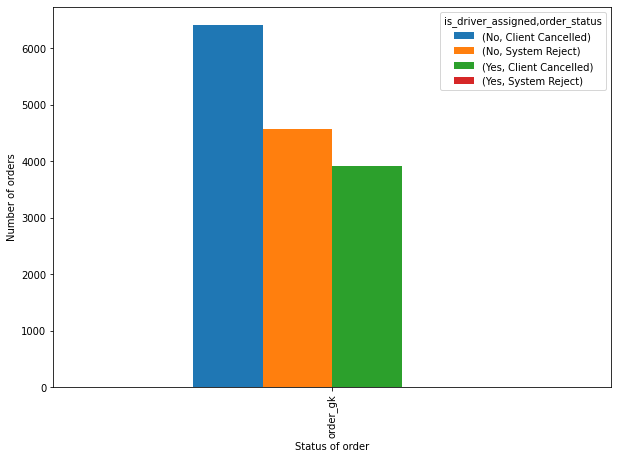

In [ ]:
df_q1.plot(kind="bar",stacked=False,figsize=(10, 7))
plt.xlabel('Status of order')
plt.ylabel('Number of orders')
plt.show()

# Question 2
Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

This question builds up upon the previous one by delving deeper into the analysis of failed orders. Rather than just plotting the distribution of fails by category (reason for cancellation, and the driver assignment), we want to know when these fails occur, and if there is some specific period in the day when one category prevails over others.

In [ ]:
# extract hour from the time column
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [ ]:
df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancelld_secs,offer_id,is_driver_assigned,order_status,order_hour
0,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986179,No,Client Cancelled,20
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,128.0,300050986174,No,Client Cancelled,20
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,46.0,300050976275,Yes,Client Cancelled,12
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,62.0,300050977907,Yes,Client Cancelled,13
4,13:50:20,-1.054671,51.460544,658.0,3000582941169,62.0,300050977914,Yes,Client Cancelled,13


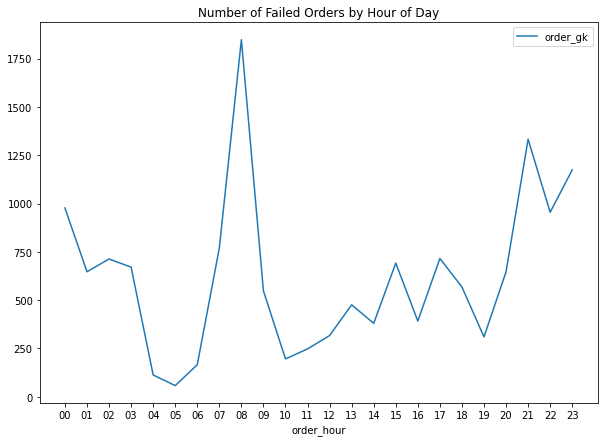

In [ ]:
df.groupby('order_hour')['order_gk'].count().plot(kind='line',figsize=(10, 7),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Number of Failed Orders by Hour of Day")


Overall Maximum failed order between 7 and 8 am, followed by between 9 and 10 pm

In [ ]:
grouped_q2=df.groupby(['order_hour','is_driver_assigned','order_status'])['order_gk'].count()
grouped_q2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled    477
                                System Reject       354
            Yes                 Client Cancelled    144
                                System Reject         2
01          No                  Client Cancelled    320
                                                   ... 
22          No                  System Reject       306
            Yes                 Client Cancelled    195
23          No                  Client Cancelled    543
                                System Reject       431
            Yes                 Client Cancelled    200
Name: order_gk, Length: 73, dtype: int64

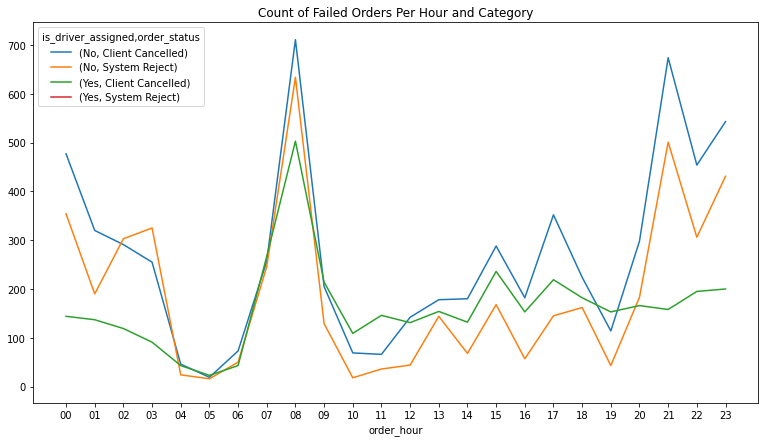

In [ ]:
grouped_q2.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")

The 2 system rejects with the assigned driver occurred around midnight (see the output of the grouped DataFrame). The rest of the categories follow similar distribution, with the client cancellations with the assigned driver having a substantially lower count during the night hours.
System rejects are High 8pm to 3am. Why?

#Question 3
Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?

To solve this question I am going to take the same approach as the previous question.

First,  aggregate the DataFrame by the order hour and the driver-assignment flag. Then, aggregate the cancellations_time_in_seconds column with the function mean. This will give  the required, aggregated information.

In [ ]:
#average cancellation time 

df.groupby(['is_driver_assigned'])['cancelld_secs'].mean()



is_driver_assigned
No     119.918822
Yes    233.243747
Name: cancelld_secs, dtype: float64

In [ ]:
grouped_q3 = df.groupby(by=["order_hour", "is_driver_assigned"])["cancelld_secs"].mean()
grouped_q3

order_hour  is_driver_assigned
00          No                    115.582809
            Yes                   275.111111
01          No                    100.937500
            Yes                   298.664234
02          No                    122.718213
            Yes                   303.638655
03          No                    123.784314
            Yes                   367.428571
04          No                     91.086957
            Yes                   260.302326
05          No                     96.421053
            Yes                   137.565217
06          No                    165.465753
            Yes                   168.511628
07          No                    143.295720
            Yes                   172.812734
08          No                    131.639944
            Yes                   189.278330
09          No                    148.156098
            Yes                   244.906542
10          No                     97.855072
            Yes         

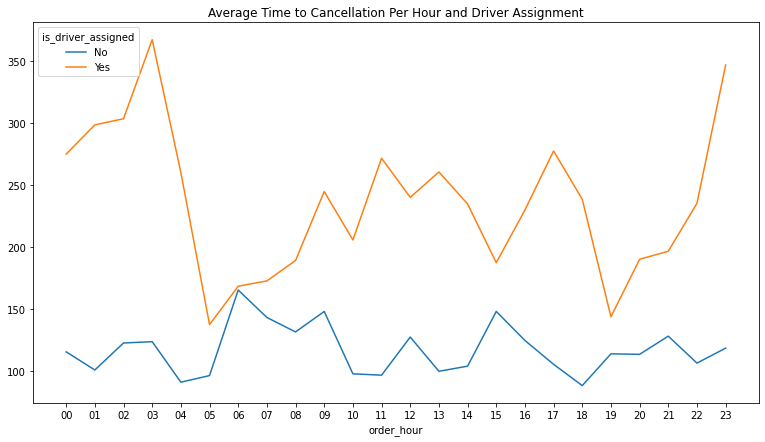

In [ ]:
grouped_q3.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancelld_secs").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

#Question 4
Plot the distribution of average ETA by hours. How can this plot be explained?

Steps: group-by the DataFrame on the order hour, and aggregate the m_order_eta column with a mean function. Then, we plot the resulting DataFrame. 

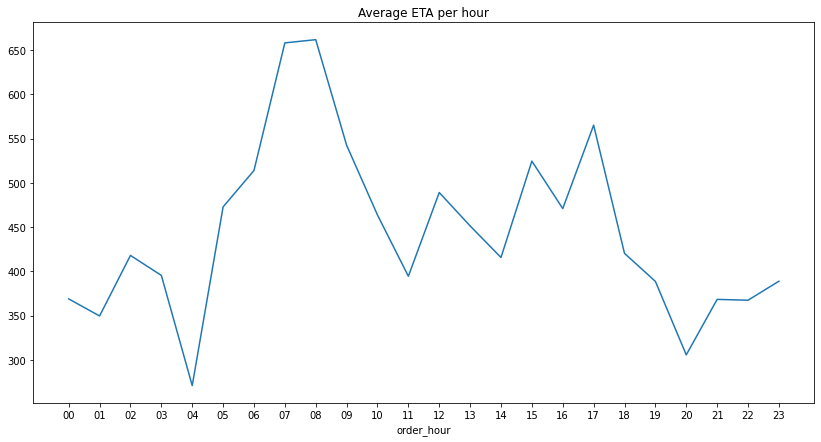

In [ ]:
df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.